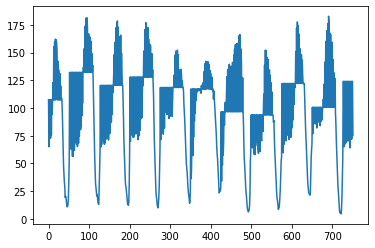

In [67]:
#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

import pandas
import numpy
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

dataset = pandas.read_csv('vermogen_laadpalen.csv', usecols=['value'])

plt.plot(dataset)
plt.show()

In [68]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [69]:
# load the dataset
dataframe = pandas.read_csv('vermogen_laadpalen.csv', usecols=['value'])
dataset = dataframe.values
#dataset = dataset.astype('float32')


In [70]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [71]:
# split into train and test sets
train_size = int(len(dataset))
train = dataset[0:train_size,:]

In [72]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [73]:
# reshape into X=t and Y=t+1
look_back = 200 #3 was good, 6 as well
trainX, trainY = create_dataset(train, look_back)

In [74]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

In [75]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
551/551 [==============================] - 1s 1ms/step - loss: 0.0283
Epoch 2/100
551/551 [==============================] - 1s 1ms/step - loss

In [76]:
# make predictions
trainPredict = model.predict(trainX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 9.29 RMSE


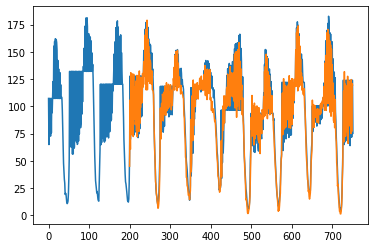

In [77]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.show()